In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *

In [144]:
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')
binary = fileToBinary('Data_Files/homecoming.txt')

print(binary[16:100])
print(toText(binary[16:160]))

CE_symbols = qpsk(CE_binary)
symbols = qpsk(Hamming74(binary))
#symbols = qpsk(binary)

001000000110100001100101011000010111001001110100001000000110100101110011001000000110
 heart is beating 


In [145]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(500,20500,1, volume = 100)

In [292]:
# For channel esimation (CE)

CE_CP = 2048
CE_N = 4096
guard = 20
CE_repeat = 50

Payload_CP = 500  # make this 600
Payload_N = 4096
# ofdmSymbols(encoded_symbols, CP_length, DFT_length, max_freq_index=0)
CE_Time, CE_Freq, CE_Long = ofdmSymbols(CE_symbols, CE_CP, CE_N)
Payload_Time, Payload_Freq, Payload_Long = ofdmSymbols(symbols, Payload_CP, Payload_N) #, max_freq_index=1024)

In [264]:
# Prepare what to transmit for channel estimation 
CE_transmit = repeat_signal(CE_Time[0], CE_repeat)
known_freq = CE_Freq[0]

Payload = np.concatenate((Payload_Time[0], Payload_Time[1], Payload_Time[2], Payload_Time[3]))

In [265]:
pause_after_chirp = 0
x = save_transmit( (chirp_signal, Pause(pause_after_chirp), CE_transmit, Payload,  Pause(0.1)) , playOutput=True)
#x = save_transmit( (Pause(1), chirp_signal) ) 
#, Pause(pause_after_chirp) ) )
print("Transmit signal is ", round(len(x)/fs, 2), " seconds")

playing
[0, 1]
[32767 32683 32434 ...     0     0     0]
Transmit signal is  8.48  seconds


In [266]:
sec = math.ceil(len(x)/fs) + 4
location = 'workdesk'
#y = record_and_save('audio_modem_test.wav', sec)
#y = audioDataFromFile('recorded_data_' + location + '.wav')
y = audioDataFromFile('Wav_Files/recording.wav')

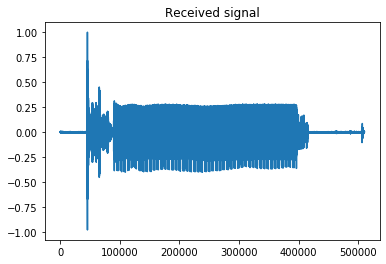

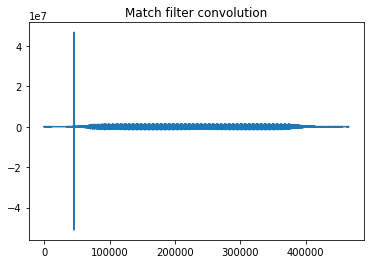

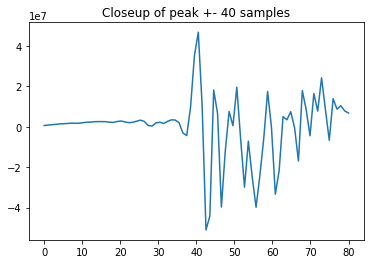

In [267]:
# obtain only the time series we are interested in 
y_dash = removeChirpAndPause(y, chirp_signal, pause_after_chirp, plot = True, rng = 40)

In [268]:
#sliceData(time_data, timeshift, N, K, repeat)
CE_samples, CE_freq, remaining = sliceData(y_dash, CE_CP-guard, CE_N, CE_CP, CE_repeat)

In [269]:
# getImpulseSimple(freq, known_freq, N, repeat)
impulse_simple, TF = getImpulseSimple(CE_freq, known_freq, len(CE_freq[0]), len(CE_freq))

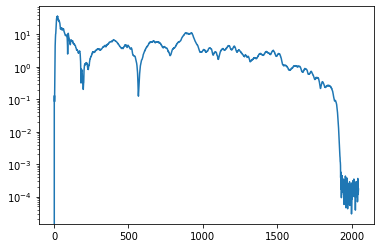

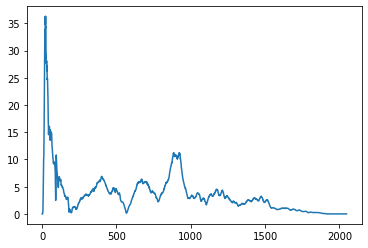

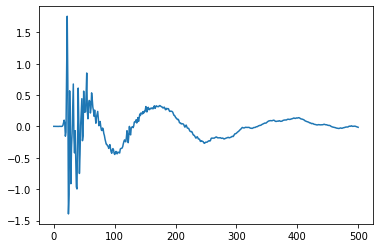

In [291]:
plt.yscale("log")
plt.plot(abs(np.array(TF))[:2048])
plot_y(abs(np.array(TF))[:2048], f=2)
plot_y(impulse_simple[:500], f=0)

In [360]:
time_data_content = remaining
dft = Payload_CP + Payload_N

#plot_y(remaining[:Payload_N*5])

#how many chunks of 1024 symbols you sent

responses = []
for n in range(4):
    samples_content = []
    freq_content = []

    # get the FFT of the data
    samples_content.append(time_data_content[dft*n:dft*(n+1)][Payload_CP-guard:Payload_CP-guard+Payload_N])
    samples_content = np.reshape(samples_content,np.zeros(Payload_N).shape)
    freq_content = fft(samples_content)


    TF_use = TF
    response = np.zeros(int((Payload_N/2) - 1), dtype = complex)

    for i in range(1,int(len(freq_content)/2)):
        #div = (freq_response[i]/ TF_use[i-1]) / cmath.rect(1, math.pi* (0.01+(real_imax)*0.001) * i)
        div2 = (freq_content[i]/TF_use[i] ) * cmath.exp((2*math.pi/Payload_N) * i * 1)
        #print(div2)
        response[i-1] += div2

    #response = np.asarray([x/repeat for x in response])
    responses.append(response)


(-1, 1)

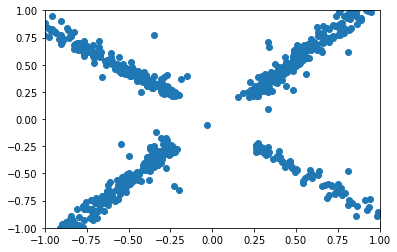

In [361]:
plot_res = np.array(responses[1])
plt.scatter(plot_res.real, plot_res.imag)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [400]:
def str_to_bytearray(string_data):
    new_data = []
    for i in range(0, len(string_data), 8):
        new_data.append(string_data[i:i+8])  

    int_data = [] 
    for i in new_data:
        int_data.append(int(i,2))

    return bytearray(int_data)

In [363]:
predict_long = ''
for res in responses:
    predict_long += iHamming74(iqpsk(res))#[strt:end]

In [404]:
data1 = np.concatenate((responses[0] , responses[1], responses[2], responses[3]))#[4*20:4*40]
#data1 = responses[0]

In [405]:
predict =iHamming74(iqpsk(data1))
actual = binary

print(len(data1))
print(len(predict))

correct = 0
for i, val in enumerate(predict):
    if val == actual[i]:
        correct += 1
        
print(correct/len(predict))
for i in range(2):
    print("est", predict[i*100:(i+1)*100])
    print("act", actual[i*100:(i+1)*100])
    print('')
    
printlen = math.floor(len(predict)/8)*8
print(printlen)
predict = predict[:printlen]

8188
9356
0.9680418982471142
est 1000000001111001001000000110100001100101011000010111001001110100001000000110100101110011001000000110
act 0100110101111001001000000110100001100101011000010111001001110100001000000110100101110011001000000110

est 0010011001010110000101110100011010010110111001100111001000000110011001110010011011110110110100100000
act 0010011001010110000101110100011010010110111001100111001000000110011001110010011011110110110100100000

9352


In [406]:
#print(decode_binary_to_text(actual))
str_to_bytearray(predict).decode('utf-8', 'replace')

'�y heart is beating from me, I am standing all alone, Please call me only if you are coming home, Waste another year flies by, Waste a night or two, You taught me how to live In the streets of shame, Where you\'ve lost your dreams in the rain, There\'s no signs of hope, The s\r�����Z�M>~(\x18�ѝm�5he last of the dope, There\'s a glow of light, The St. Jimmy is the spark in the �ight, Bearing gifts and trust, The fixture in the city of lust, "What the hells your name, What\'s your pleasure and what\'s your pain? Do you dream too much? Do you think what you need is a cruw��<\x1b�QY\x1e~��\x1e\x1f\x12�\x17/��f pain, St. Jimmy comes without any shame, He says "We\'re *****ed up", But we\'re not the same, And mom and dad are the ones you can blame Jimmy died today He blew his brains out into the bay, In the state of mind in my own private suicide Well nobody cares, Well nobody carmo�����\u061dW-~}\x02�����e if nobody cares? Well noaody cares, Well nobody cares, Does anyone care if nobody ca